In [ ]:
import numpy as np
import librosa

In [ ]:
hop_length = 512
n_fft = 1024

In [ ]:
def audio_to_log_magnitude(file_path, sr=22050, n_fft=1024, hop_length=hop_length):
    y, _ = librosa.load(file_path, sr=sr)
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    mag = np.log1p(np.abs(S))  # log escalado
    return mag.astype(np.float32), sr


In [ ]:
def split_into_windows(mag, window_size=512, step_size=256):
    num_frames = mag.shape[1]
    windows = []
    for start in range(0, num_frames - window_size + 1, step_size):
        window = mag[:, start:start + window_size]
        windows.append(window)
    return np.array(windows)[..., np.newaxis]  # (num_windows, freq_bins, frames, 1)


In [ ]:
def reconstruct_from_windows(windows, window_size=512, step_size=256):
    freq_bins = windows.shape[1]
    total_frames = (windows.shape[0] - 1) * step_size + window_size
    output = np.zeros((freq_bins, total_frames))
    weight = np.zeros((freq_bins, total_frames))

    for i, win in enumerate(windows):
        start = i * step_size
        output[:, start:start + window_size] += win[..., 0]
        weight[:, start:start + window_size] += 1.0

    return output / (weight + 1e-8)


In [ ]:
def spectrogram_to_audio(mag, n_fft=1024, hop_length=hop_length, iterations=60):
    mag = np.expm1(mag)
    phase = np.exp(2j * np.pi * np.random.rand(*mag.shape))
    S = mag * phase
    for _ in range(iterations):
        y = librosa.istft(S, hop_length=hop_length)
        S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
        phase = np.exp(1j * np.angle(S))
        S = mag * phase
    y = librosa.istft(S, hop_length=hop_length)
    return y


In [ ]:
def stylize_audio_blocks(encoder, decoder, content_mag, style_mag=None, alpha=0.5,
                         window_size=512, step_size=256):
    content_windows = split_into_windows(content_mag, window_size, step_size)

    if style_mag is not None:
        style_windows = split_into_windows(style_mag, window_size, step_size)

    stylized_windows = []
    for i in range(len(content_windows)):
        content_block = content_windows[i]
        content_emb = encoder.predict(content_block[np.newaxis, ...])

        if style_mag is not None:
            style_block = style_windows[i % len(style_windows)]
            style_emb = encoder.predict(style_block[np.newaxis, ...])
            mixed_emb = (1 - alpha) * content_emb + alpha * style_emb
        else:
            mixed_emb = content_emb

        stylized_block = decoder.predict(mixed_emb)[0]
        stylized_windows.append(stylized_block)

    stylized_mag = reconstruct_from_windows(np.array(stylized_windows), window_size, step_size)
    return stylized_mag


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_autoencoder(input_shape, latent_dim=128):
    # Encoder
    encoder_input = tf.keras.Input(shape=input_shape)
    x = layers.Flatten()(encoder_input)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(latent_dim, activation='relu')(x)
    encoder = tf.keras.Model(encoder_input, x, name='encoder')

    # Decoder
    decoder_input = tf.keras.Input(shape=(latent_dim,))
    x = layers.Dense(512, activation='relu')(decoder_input)
    x = layers.Dense(np.prod(input_shape), activation='linear')(x)
    x = layers.Reshape(input_shape)(x)
    decoder = tf.keras.Model(decoder_input, x, name='decoder')

    # Autoencoder
    auto_input = encoder_input
    encoded = encoder(auto_input)
    decoded = decoder(encoded)
    autoencoder = tf.keras.Model(auto_input, decoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder, decoder

In [ ]:
import soundfile as sf

def style_transfer_pipeline(content_path, style_path, output_path,
                            encoder, decoder,
                            window_size=256,  # Change window_size to 256 to match training data shape
                            step_size=256,
                            alpha=0.5, sr=22050):

    content_mag, _ = audio_to_log_magnitude(content_path, sr=sr)
    style_mag, _ = audio_to_log_magnitude(style_path, sr=sr)

    stylized_mag = stylize_audio_blocks(encoder, decoder,
                                        content_mag, style_mag,
                                        alpha=alpha,
                                        window_size=window_size, # Pass the corrected window_size
                                        step_size=step_size)

    audio_out = spectrogram_to_audio(stylized_mag)
    sf.write(output_path, audio_out, sr)


In [ ]:
import librosa
import numpy as np
import os

def audio_to_spectrogram(file_path, sr=22050, n_fft=1024, hop_length=256):
    y, _ = librosa.load(file_path, sr=sr)
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    mag = np.log1p(np.abs(S))  # log-scaled magnitude
    return mag.astype(np.float32)

In [ ]:
def load_dataset(folder, shape=(513, 256)):
    X = []
    for fname in os.listdir(folder):
        if fname.endswith('.wav'):
            mag = audio_to_spectrogram(os.path.join(folder, fname))
            if mag.shape[1] >= shape[1]:
                mag = mag[:, :shape[1]]  # crop to fixed size
                X.append(mag)
    X = np.array(X)[..., np.newaxis]  # add channel dim
    return X

In [ ]:
folder = './'  # carpeta con .wav
X_train = load_dataset(folder)
input_shape = X_train.shape[1:]  # (513, 256, 1)
autoencoder, encoder, decoder = build_autoencoder(input_shape, latent_dim=128)

autoencoder.fit(X_train, X_train, epochs=50, batch_size=8)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1549
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1477
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0987
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0807
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1238
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0646
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0592
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0551
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0390
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0308
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0254
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0206
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0165
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0123
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0093
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0069
E

In [ ]:
style_transfer_pipeline(
    content_path='short_bohemian-2.wav',
    #style_path='short_huapango-2.wav',
    style_path='short_la_bruja.wav',
    output_path='output_stylized_bohemia_labruja_v1.wav',
    encoder=encoder,
    decoder=decoder,
    window_size=256,
    step_size=128,
    alpha=0.03
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━

In [ ]:
from librosa.display import specshow

In [ ]:
def plot_spec(audio):
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)
  specshow(D, y_axis='log')

<ipython-input-48-dfbb6d2a7dd2>:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)


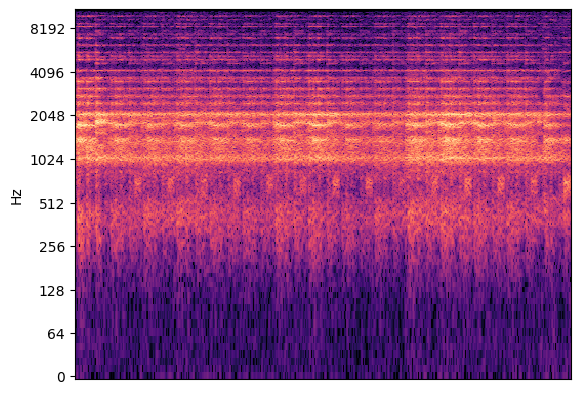

In [ ]:
sr = 5550
content = './output_stylized_bohemia_labruja_v1.wav'
audio, _ = librosa.core.load(content, sr=sr)
aa = plot_spec(audio)

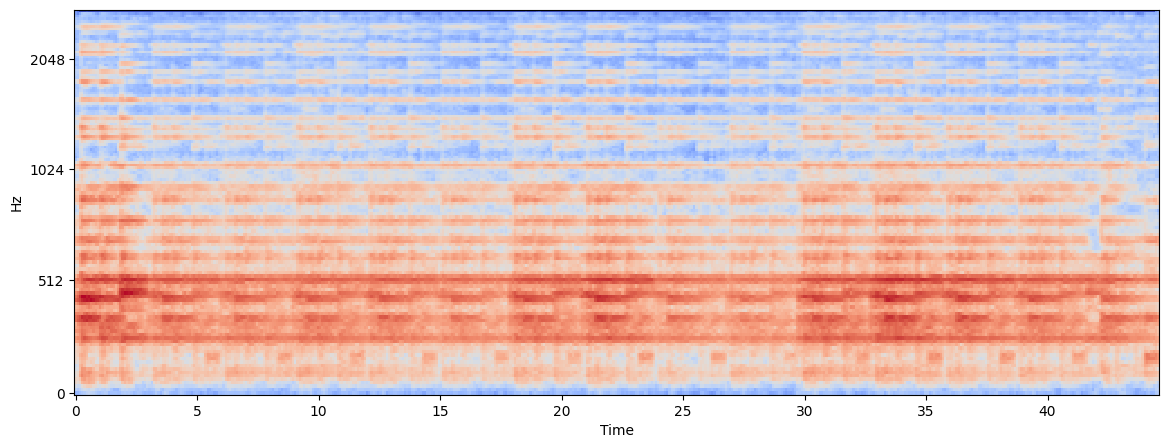

In [ ]:
import matplotlib.pyplot as plt

sr = 5550
# content = './output_stylized_bohemia_nut.wav'
# audio, _ = librosa.core.load(content, sr=sr)

def mel_spec(y):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    return librosa.power_to_db(S)


plt.figure(figsize=(14, 5))
mel_audio = mel_spec(audio)
librosa.display.specshow(mel_audio, sr=sr, x_axis='time', y_axis='mel')

In [ ]:
from IPython.display import Audio

In [ ]:
Audio(audio, rate=sr)

In [ ]:
#import librosa
#y, sr = librosa.load("reconstructed_vibeace.wav", sr=None)
#print(f"Duración: {len(y) / sr:.2f} segundos")


In [ ]:
style_transfer_pipeline(
    content_path='short_bohemian-2.wav',
    #style_path='short_huapango-2.wav',
    style_path='short_la_bruja.wav',
    output_path='output_stylized_bohemia_labruja_v1.wav',
    encoder=encoder,
    decoder=decoder,
    window_size=256,
    step_size=128,
    alpha=0.4
)

## New Aproach


In [ ]:
import numpy as np
import librosa
import soundfile as sf
import tensorflow as tf
from scipy.signal import get_window
from tqdm import tqdm

# === AUDIO PROCESSING HELPERS ===
def audio_to_log_magnitude(filepath, n_fft=1024, hop_length=256, sr=22050):
    y, _ = librosa.load(filepath, sr=sr)
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(S)
    log_mag = np.log1p(magnitude)
    return log_mag, sr

def log_magnitude_to_audio(log_mag, n_fft=1024, hop_length=256, iterations=100):
    mag = np.expm1(log_mag)
    phase = np.exp(2j * np.pi * np.random.rand(*mag.shape))
    for _ in range(iterations):
        S = mag * phase
        y = librosa.istft(S, hop_length=hop_length)
        phase = np.exp(1j * np.angle(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)))
    return y

def extract_windows(spec, window_size, step_size):
    windows = []
    for start in range(0, spec.shape[1] - window_size + 1, step_size):
        end = start + window_size
        windows.append(spec[:, start:end])
    return np.array(windows)

def reconstruct_from_windows(windows, window_size, step_size, spec_shape):
    output = np.zeros(spec_shape)
    weight = np.zeros(spec_shape)
    idx = 0
    for start in range(0, spec_shape[1] - window_size + 1, step_size):
        end = start + window_size
        output[:, start:end] += windows[idx]
        weight[:, start:end] += 1
        idx += 1
    return output / (weight + 1e-8)


# === STYLE TRANSFER USING AUTOENCODER ===
def stylize_windows(encoder, decoder, content_windows, style_windows, alpha=0.5):
    stylized_windows = []
    for i in range(len(content_windows)):
        content_block = content_windows[i]
        style_block = style_windows[i % len(style_windows)]  # Loop if shorter

        # Expand dims for model
        c_input = content_block[np.newaxis, ..., np.newaxis]
        s_input = style_block[np.newaxis, ..., np.newaxis]

        # Encode
        c_embed = encoder.predict(c_input)
        s_embed = encoder.predict(s_input)

        # Blend
        combined_embed = (1 - alpha) * c_embed + alpha * s_embed

        # Decode
        stylized = decoder.predict(combined_embed)[0, ..., 0]
        stylized_windows.append(stylized)
    return np.array(stylized_windows)

# === MAIN PIPELINE ===
def style_transfer_sliding_pipeline(content_path, style_path, output_path,
                                    encoder, decoder,
                                    n_fft=1024, hop_length=256,
                                    window_size=64, step_size=32,
                                    alpha=0.5, sr=22050):
    content_mag, _ = audio_to_log_magnitude(content_path, n_fft=n_fft, hop_length=hop_length, sr=sr)
    style_mag, _ = audio_to_log_magnitude(style_path, n_fft=n_fft, hop_length=hop_length, sr=sr)

    # Pad if style is shorter
    min_frames = min(content_mag.shape[1], style_mag.shape[1])
    content_mag = content_mag[:, :min_frames]
    style_mag = style_mag[:, :min_frames]

    # Extract windows
    content_windows = extract_windows(content_mag, window_size, step_size)
    style_windows = extract_windows(style_mag, window_size, step_size)

    # Stylize
    stylized_windows = stylize_windows(encoder, decoder, content_windows, style_windows, alpha=alpha)

    # Reconstruct full spectrogram
    full_stylized = reconstruct_from_windows(stylized_windows, window_size, step_size, content_mag.shape)

    # Reconstruct audio
    y = log_magnitude_to_audio(full_stylized, n_fft=n_fft, hop_length=hop_length)
    sf.write(output_path, y, sr)


In [ ]:
folder = './'  # carpeta con .wav
X_train = load_dataset(folder)
input_shape = X_train.shape[1:]  # (513, 256, 1)
autoencoder, encoder, decoder = build_autoencoder(input_shape, latent_dim=128)

autoencoder.fit(X_train, X_train, epochs=50, batch_size=8)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1407
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1361
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0976
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0772
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0681
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0639
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0431
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0412
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0326
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0284
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0197
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0156
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0126
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0116
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0095
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0082
E

In [ ]:
content_path='short_bohemian-2.wav'
style_path='short_la_bruja.wav'
output_path='output_stylized_bohemia_labruja_v1_1.wav'

In [ ]:
style_transfer_sliding_pipeline(content_path, style_path, output_path,
                                    encoder, decoder,
                                    n_fft=1024, hop_length=120,
                                    window_size=256, step_size=32,
                                    alpha=0.8, sr=22050)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

<ipython-input-48-dfbb6d2a7dd2>:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)


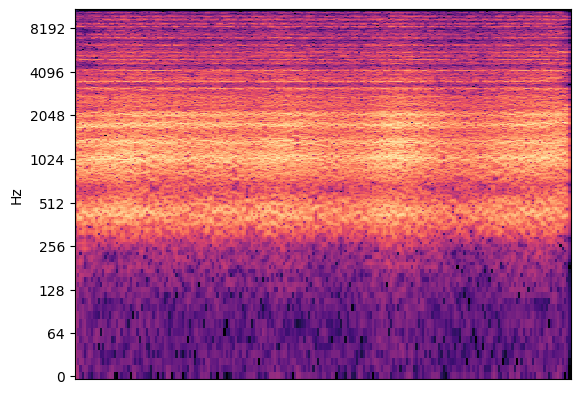

In [ ]:
sr = 5550
content = './output_stylized_bohemia_labruja_v1_1.wav'
audio, _ = librosa.core.load(content, sr=sr)
aa = plot_spec(audio)

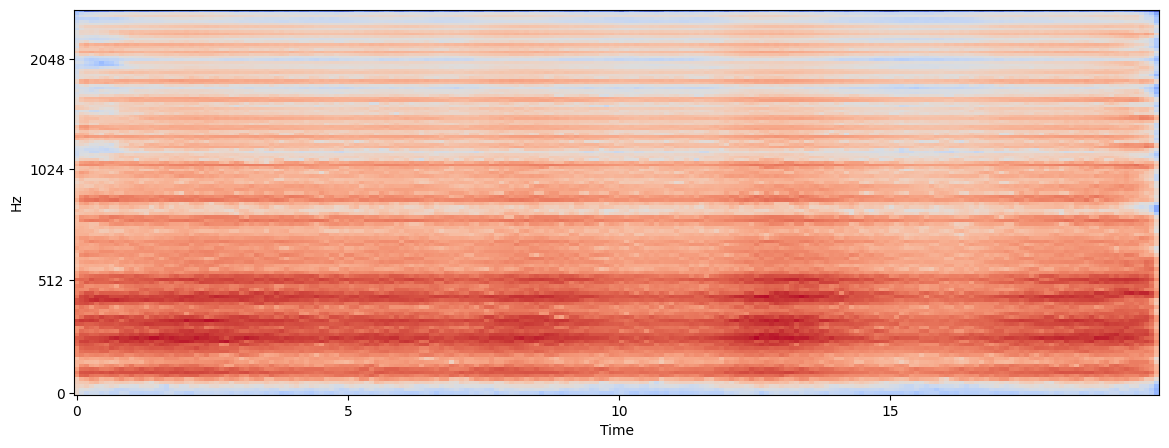

In [ ]:
import matplotlib.pyplot as plt

sr = 5550
# content = './output_stylized_bohemia_nut.wav'
# audio, _ = librosa.core.load(content, sr=sr)

def mel_spec(y):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    return librosa.power_to_db(S)


plt.figure(figsize=(14, 5))
mel_audio = mel_spec(audio)
librosa.display.specshow(mel_audio, sr=sr, x_axis='time', y_axis='mel')

In [ ]:
from IPython.display import Audio

In [ ]:
Audio(audio, rate=sr)